# Economic Fitness and Complexity


### Learning Objectives
By the end of this tutorial, you will be able to:
1. Understand the concept of **economic fitness** as a measure of industrial development
2. Compute **Revealed Comparative Advantage (RCA)** and binarize trade matrices
3. Visualize the **nested structure** of the world trade network
4. Implement the **fitness-complexity algorithm**
5. Analyze the relationship between fitness and GDP per capita
6. Identify countries with high/low fitness relative to their GDP

### What is Economic Fitness?

**Economic fitness** is a measure of a country's industrial development that captures:
- **Diversification**: How many different products a country exports
- **Sophistication**: How complex/rare those products are

Unlike GDP, fitness specifically measures **productive capabilities** - the know-how and infrastructure needed to make diverse, complex products.

### Key Concepts

- **Fitness (F)**: Country's productive capabilities
- **Complexity (Q)**: Product sophistication
- **Nestedness**: Pattern where diverse countries make all products that specialized countries make

---

## Step 1: Import Libraries and Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Set style
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

### Load Trade Data

We use the same export matrix from 2021 that we used in the bipartite network analysis.

In [2]:
# Import export matrix
export_df = pd.read_csv('exportmatrix2021.csv', header=None)
export_matrix = export_df.values

# Import country list
countries_df = pd.read_csv('countries.csv', header=None)
countries = countries_df[0].tolist()

# Import product list
products_df = pd.read_csv('products.csv', header=None)
products = products_df[0].tolist()

print(f"Loaded export matrix: {len(countries)} countries × {len(products)} products")
print(f"Total export value: ${export_matrix.sum():,.0f}")
print(f"Matrix shape: {export_matrix.shape}")

Loaded export matrix: 169 countries × 5206 products
Total export value: $21,328,977,422,113
Matrix shape: (169, 5206)


---
## Step 2: Compute RCA and Binarize the Matrix

### Revealed Comparative Advantage (RCA)

RCA measures whether a country specializes in a product relative to world trade patterns:

$$
\text{RCA}(c,p) = \frac{X(c,p)/X_c}{X_p/X_{\text{total}}}
$$

Where:
- $X(c,p)$: Export value of product $p$ by country $c$
- $X_c$: Total exports of country $c$
- $X_p$: Total exports of product $p$
- $X_{\text{total}}$: Total global exports

**Binarization**: We set $M(c,p) = 1$ if $\text{RCA}(c,p) \geq 1$, else $M(c,p) = 0$

In [3]:
def rca_matrix(mat, binarization=True):
    """
    Compute Revealed Comparative Advantage and optionally binarize.

    Parameters:
    -----------
    mat : numpy array
        Export matrix (countries × products)
    binarization : bool
        If True, return binary matrix (1 if RCA >= 1, else 0)

    Returns:
    --------
    RCA : numpy array
        RCA values or binary matrix
    """
    u = np.sum(mat, axis=0)  # Product totals
    d = np.sum(mat, axis=1)  # Country totals
    t = np.sum(mat)          # Global total

    # Compute RCA: (mat * t / u).T / d
    # Handle division by zero with nan_to_num
    RCA = np.nan_to_num((mat * t / u).T / d).T

    if binarization:
        RCA[RCA >= 1] = 1
        RCA[RCA < 1] = 0

    return RCA

In [4]:
# Compute RCA and binarize
M = rca_matrix(export_matrix, binarization=True)

print(f"Binary matrix shape: {M.shape}")
print(f"Total links (RCA >= 1): {M.sum():.0f}")
print(f"Network density: {M.sum() / M.size:.4f}")

Binary matrix shape: (169, 5206)
Total links (RCA >= 1): 88066
Network density: 0.1001


/tmp/ipython-input-3725450583.py:23: RuntimeWarning: invalid value encountered in divide
  RCA = np.nan_to_num((mat * t / u).T / d).T


### Clean the Data

Remove countries with no exports and products not exported by any country.

In [5]:
# Compute initial diversification and ubiquity
div = np.sum(M, axis=1)  # Country diversification (number of products)
ubi = np.sum(M, axis=0)  # Product ubiquity (number of countries)

print(f"Countries with zero diversification: {(div == 0).sum()}")
print(f"Products with zero ubiquity: {(ubi == 0).sum()}")

# Identify rows and columns to remove
countries_to_remove = div == 0
products_to_remove = ubi == 0

# Filter matrix and country list
M_clean = np.delete(M, countries_to_remove, axis=0)
M_clean = np.delete(M_clean, products_to_remove, axis=1)
countries_clean = [c for i, c in enumerate(countries) if not countries_to_remove[i]]

print(f"\nCleaned matrix shape: {M_clean.shape}")
print(f"Removed {countries_to_remove.sum()} countries and {products_to_remove.sum()} products")

Countries with zero diversification: 0
Products with zero ubiquity: 3

Cleaned matrix shape: (169, 5203)
Removed 0 countries and 3 products


In [6]:
# Recompute after cleaning
div_clean = np.sum(M_clean, axis=1)
ubi_clean = np.sum(M_clean, axis=0)

print(f"Diversification range: [{div_clean.min():.0f}, {div_clean.max():.0f}]")
print(f"Ubiquity range: [{ubi_clean.min():.0f}, {ubi_clean.max():.0f}]")
print(f"Average diversification: {div_clean.mean():.2f}")
print(f"Average ubiquity: {ubi_clean.mean():.2f}")

Diversification range: [15, 2291]
Ubiquity range: [1, 87]
Average diversification: 521.10
Average ubiquity: 16.93


---
## Step 3: Visualize the Nested Structure

### What is Nestedness?

The world trade network exhibits a **nested structure**:
- **Diverse countries** (high diversification) export almost everything
- **Specialized countries** (low diversification) export only a subset
- The products made by specialized countries are a **subset** of those made by diverse countries

This creates a triangular pattern when we order:
- **Countries** by diversification (low to high)
- **Products** by ubiquity (high to low)

In [7]:
# Order matrix to reveal nested structure
# Sort countries by diversification (ascending: least to most diverse)
country_order = np.argsort(div_clean)

# Sort products by ubiquity (descending: most to least common)
product_order = np.argsort(ubi_clean)[::-1]

# Reorder matrix
M_ordered = M_clean[np.ix_(country_order, product_order)]

print(f"Matrix reordered: {M_ordered.shape}")
print(f"Density: {M_ordered.sum() / M_ordered.size:.4f}")

Matrix reordered: (169, 5203)
Density: 0.1002


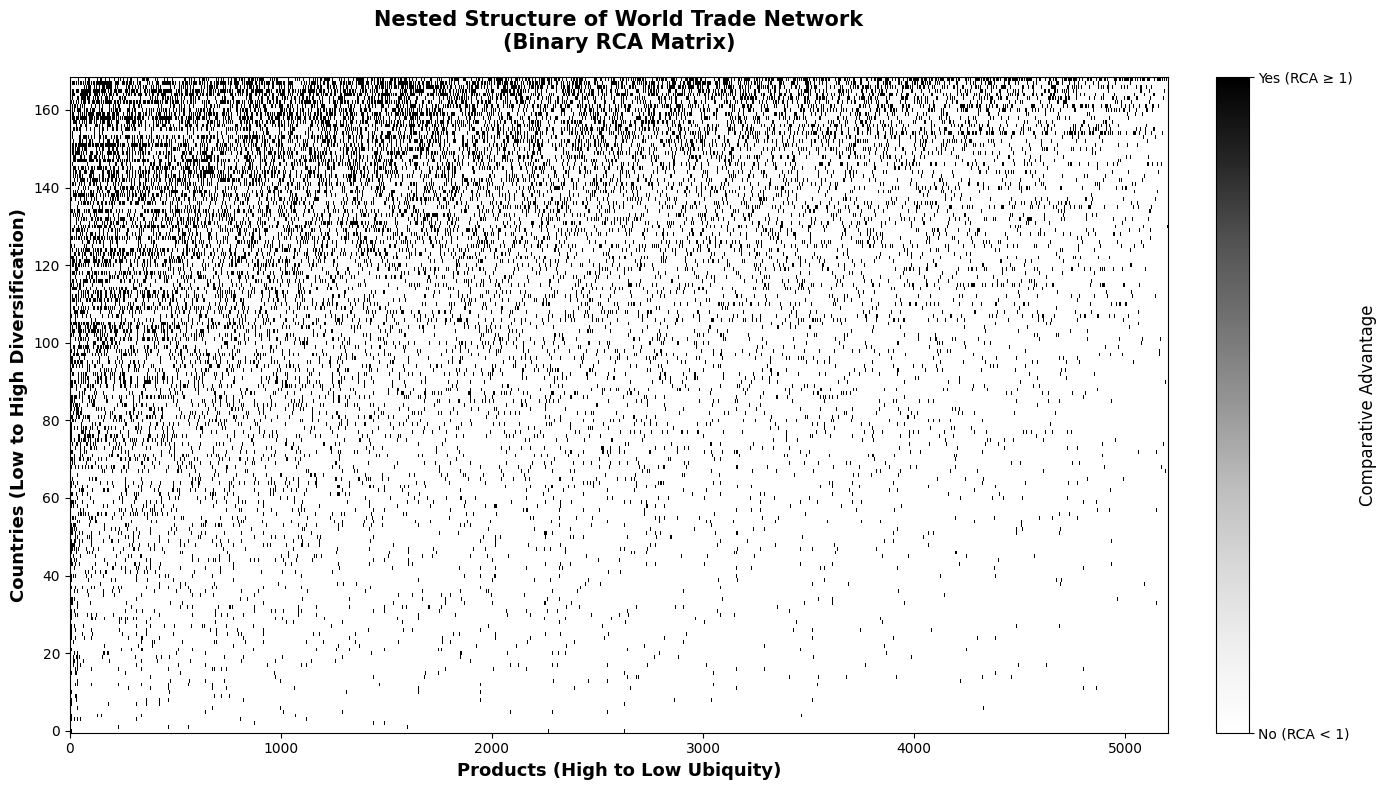

In [8]:
# Visualize nested structure
fig, ax = plt.subplots(figsize=(14, 8))

# Plot matrix
im = ax.imshow(M_ordered, aspect='auto', cmap='Greys', origin='lower', interpolation='nearest')

# Labels and title
ax.set_xlabel('Products (High to Low Ubiquity)', fontsize=13, fontweight='bold')
ax.set_ylabel('Countries (Low to High Diversification)', fontsize=13, fontweight='bold')
ax.set_title('Nested Structure of World Trade Network\n(Binary RCA Matrix)',
             fontsize=15, fontweight='bold', pad=20)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Comparative Advantage', fontsize=12)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['No (RCA < 1)', 'Yes (RCA ≥ 1)'])


plt.tight_layout()
plt.savefig('nested_export_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### Interpretation

**What does this pattern mean?**

1. **Bottom-left corner** (black): Specialized countries export only common products
2. **Top-right corner** (white): Even diverse countries don't export very rare/complex products
3. **Top-left corner** (black): Diverse countries export almost everything
4. **Triangular pattern**: Shows economic development hierarchy

This nested structure is a fundamental feature of economic development!

---
## Step 4: Fitness-Complexity Algorithm

### The Iterative Method

Fitness and complexity are defined through **mutual feedback**:

**Country Fitness** $F_c$ increases if the country exports many **complex** products:
$$
F_c^{(n+1)} = \sum_p M(c,p) \cdot Q_p^{(n)}
$$

**Product Complexity** $Q_p$ increases if the product is exported by countries with **low fitness**:
$$
Q_p^{(n+1)} = \left( \sum_c M(c,p) \cdot \frac{1}{F_c^{(n)}} \right)^{-1}
$$

**Normalization** after each iteration:
$$
F_c^{(n+1)} \leftarrow \frac{F_c^{(n+1)}}{\langle F_c^{(n+1)} \rangle}, \quad
Q_p^{(n+1)} \leftarrow \frac{Q_p^{(n+1)}}{\langle Q_p^{(n+1)} \rangle}
$$

### Intuition

- **Complex products**: Hard to make, only produced by capable countries
- **Fit countries**: Can make many complex products
- The algorithm finds the **fixed point** of this mutual relationship

In [9]:
def compute_fitness_complexity(M, iterations=100):
    """
    Compute country fitness and product complexity using the iterative algorithm.

    Parameters:
    -----------
    M : numpy array
        Binary matrix (countries × products)
    iterations : int
        Number of iterations

    Returns:
    --------
    F : numpy array
        Country fitness values
    Q : numpy array
        Product complexity values
    """
    N_c, N_p = M.shape

    # Initialize
    F = np.ones(N_c)
    Q = np.ones(N_p)

    for iteration in range(iterations):
        # Update fitness: sum of product complexities
        F_new = M @ Q

        # Update complexity: inverse of sum of inverse fitnesses
        Q_new = 1 / (M.T @ (1 / F_new))

        # Normalize
        F = F_new / np.mean(F_new)
        Q = Q_new / np.mean(Q_new)

        # Optional: print convergence every 20 iterations
        if (iteration + 1) % 20 == 0:
            print(f"Iteration {iteration + 1}: F range [{F.min():.4f}, {F.max():.4f}], "
                  f"Q range [{Q.min():.4f}, {Q.max():.4f}]")

    return F, Q

In [10]:
# Compute fitness and complexity
print("Computing fitness and complexity...\n")
F, Q = compute_fitness_complexity(M_clean, iterations=100)

print(f"\nFitness statistics:")
print(f"  Mean: {F.mean():.4f} (by construction)")
print(f"  Std: {F.std():.4f}")
print(f"  Range: [{F.min():.4f}, {F.max():.4f}]")

print(f"\nComplexity statistics:")
print(f"  Mean: {Q.mean():.4f} (by construction)")
print(f"  Std: {Q.std():.4f}")
print(f"  Range: [{Q.min():.4f}, {Q.max():.4f}]")

Computing fitness and complexity...

Iteration 20: F range [0.0000, 11.5691], Q range [0.0000, 89.9987]
Iteration 40: F range [0.0000, 11.6069], Q range [0.0000, 90.4147]
Iteration 60: F range [0.0000, 11.6118], Q range [0.0000, 90.4689]
Iteration 80: F range [0.0000, 11.6132], Q range [0.0000, 90.4847]
Iteration 100: F range [0.0000, 11.6138], Q range [0.0000, 90.4915]

Fitness statistics:
  Mean: 1.0000 (by construction)
  Std: 1.7050
  Range: [0.0000, 11.6138]

Complexity statistics:
  Mean: 1.0000 (by construction)
  Std: 3.5705
  Range: [0.0000, 90.4915]


### Analyze Country Fitness

In [11]:
# Create DataFrame with fitness results
df_fitness = pd.DataFrame({
    'Country': countries_clean,
    'Fitness': F,
    'Diversification': div_clean
})

# Sort by fitness
df_fitness_sorted = df_fitness.sort_values('Fitness', ascending=False)

print("\nTop 20 Countries by Fitness:\n")
print(df_fitness_sorted[['Country', 'Fitness', 'Diversification']].head(20).to_string(index=False))


Top 20 Countries by Fitness:

Country   Fitness  Diversification
    CHN 11.613768           2291.0
    DEU  8.296669           2054.0
    JPN  7.023757           1360.0
    USA  6.321233           1645.0
    ITA  6.143947           2207.0
    IND  5.925281           1663.0
    FRA  5.190828           1870.0
    NLD  4.739421           1615.0
    ESP  4.478823           1994.0
    BEL  4.127957           1384.0
    AUT  3.943012           1512.0
    GBR  3.829058           1453.0
    KOR  3.793377            882.0
    POL  3.680924           1565.0
    CZE  3.547189           1273.0
    TUR  3.018145           1653.0
    SWE  2.933638           1165.0
    CHE  2.864123            736.0
    PRT  2.670912           1518.0
    THA  2.624184           1060.0


In [12]:
print("\nBottom 20 Countries by Fitness:\n")
print(df_fitness_sorted[['Country', 'Fitness', 'Diversification']].tail(20).to_string(index=False))


Bottom 20 Countries by Fitness:

Country      Fitness  Diversification
    MDV 4.069231e-03             83.0
    GUY 3.582026e-03             86.0
    GRL 3.209284e-03             55.0
    DZA 1.857792e-03             68.0
    PNG 1.284486e-04             58.0
    QAT 8.346031e-05             50.0
    COG 6.049226e-08             65.0
    COD 7.691884e-09             46.0
    SSD 2.146790e-09             37.0
    LBR 4.427431e-11             44.0
    GAB 1.709290e-11             47.0
    AGO 1.537843e-11             41.0
    GIN 3.310855e-14             40.0
    ERI 2.688743e-15             26.0
    LBY 1.126307e-16             32.0
    MLI 9.858818e-17             38.0
    IRQ 2.223989e-23             23.0
    GNB 1.578804e-32             19.0
    TCD 3.571610e-37             15.0
    GNQ 3.513394e-37             15.0


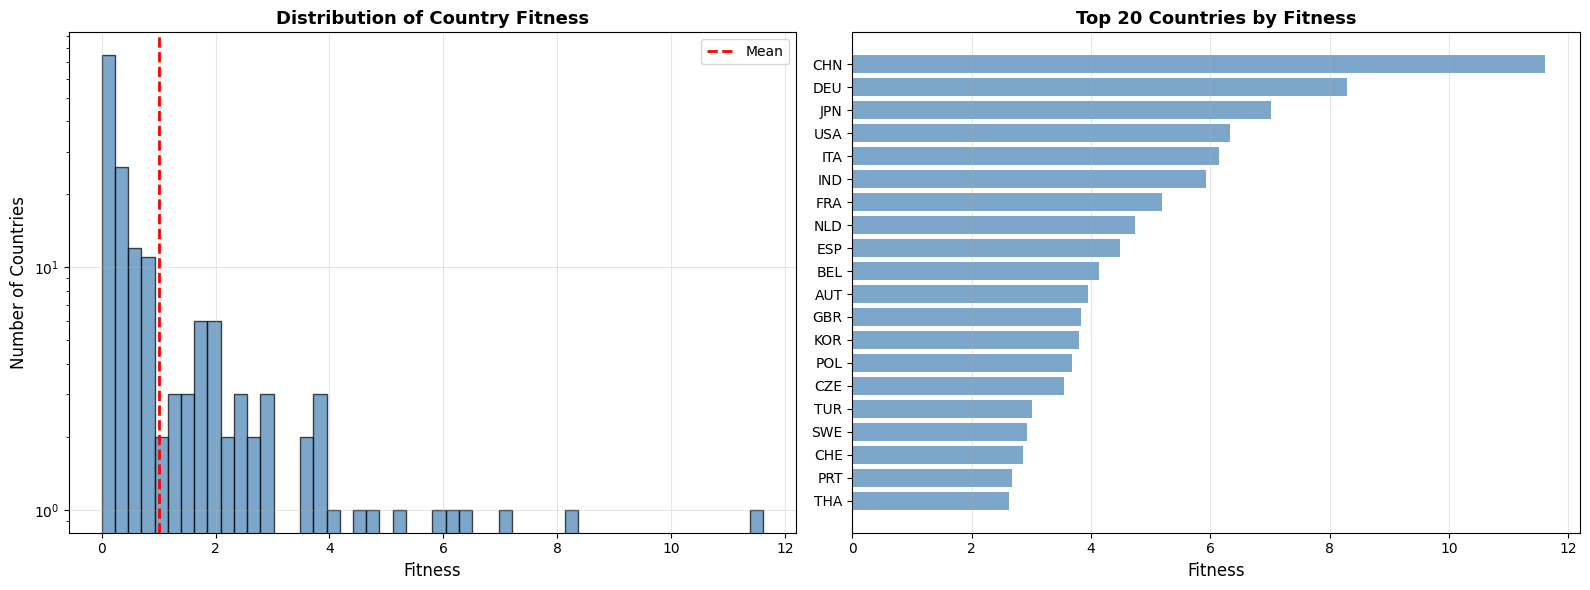

In [13]:
# Visualize fitness distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(F, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Fitness', fontsize=12)
axes[0].set_ylabel('Number of Countries', fontsize=12)
axes[0].set_title('Distribution of Country Fitness', fontsize=13, fontweight='bold')
axes[0].axvline(F.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Top 20 bar plot
top20 = df_fitness_sorted.head(20)
axes[1].barh(range(20), top20['Fitness'].values, color='steelblue', alpha=0.7)
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top20['Country'].values)
axes[1].invert_yaxis()
axes[1].set_xlabel('Fitness', fontsize=12)
axes[1].set_title('Top 20 Countries by Fitness', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### Fitness vs. Diversification

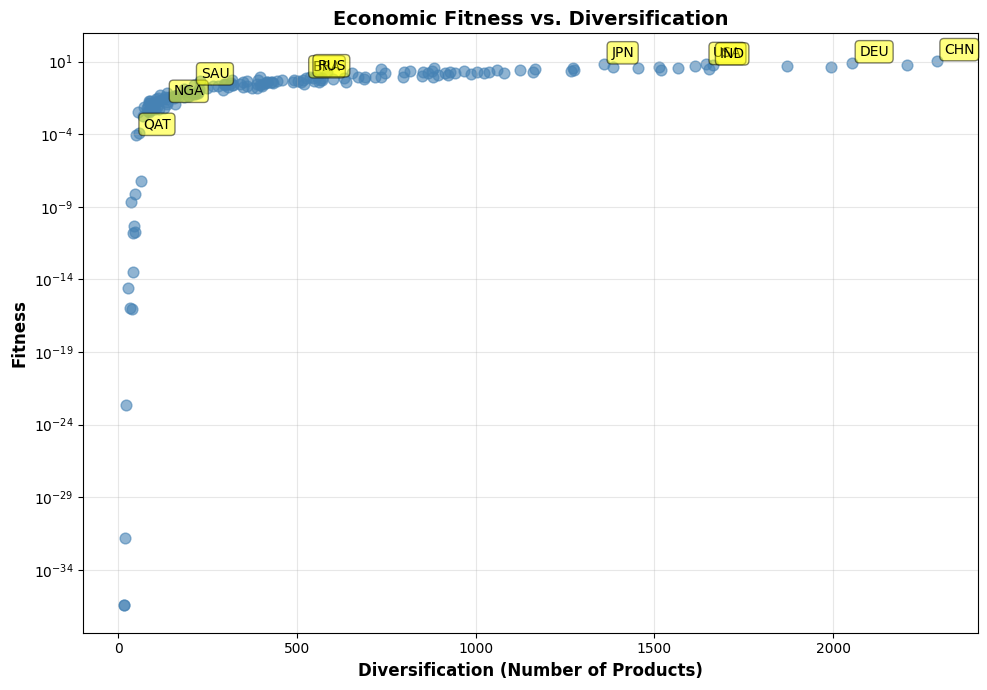


Note: Fitness is not just diversification!
Countries with similar diversification can have very different fitness.
Fitness accounts for the COMPLEXITY of products exported.


In [14]:
# Scatter plot: fitness vs diversification
plt.figure(figsize=(10, 7))

plt.scatter(df_fitness['Diversification'], df_fitness['Fitness'],
            alpha=0.6, s=60, color='steelblue')

# Label some key countries
key_countries = ['CHN', 'USA', 'DEU', 'JPN', 'IND', 'BRA', 'RUS', 'NGA', 'SAU', 'QAT']
for country in key_countries:
    if country in df_fitness['Country'].values:
        row = df_fitness[df_fitness['Country'] == country].iloc[0]
        plt.annotate(country, (row['Diversification'], row['Fitness']),
                    xytext=(5, 5), textcoords='offset points', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

plt.xlabel('Diversification (Number of Products)', fontsize=12, fontweight='bold')
plt.ylabel('Fitness', fontsize=12, fontweight='bold')
plt.title('Economic Fitness vs. Diversification', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nNote: Fitness is not just diversification!")
print("Countries with similar diversification can have very different fitness.")
print("Fitness accounts for the COMPLEXITY of products exported.")

---
## Step 5: Fitness vs. GDP per Capita

### Load GDP Data

We compare fitness against GDP per capita (PPP) to see:
- How well fitness predicts economic development
- Which countries are over/underperforming relative to their productive capabilities

In [15]:
# Load GDP data
gdp_data = pd.read_csv('gdp_ppp.csv', usecols=["Country Code", "2021 [YR2021]"])
gdp_data.columns = ['country_code', 'gdp_pc']
print("GDP data loaded successfully")
print(f"Number of countries with GDP data: {len(gdp_data)}")

GDP data loaded successfully
Number of countries with GDP data: 217


In [16]:
# Merge fitness with GDP data
df_merged = df_fitness.merge(gdp_data, left_on='Country', right_on='country_code', how='left')

# Clean data
# Remove rows with missing GDP
df_merged = df_merged[df_merged['gdp_pc'].notna()]

# Handle '..' (World Bank missing data indicator)
df_merged['gdp_pc'] = df_merged['gdp_pc'].replace('..', np.nan)
df_merged = df_merged[df_merged['gdp_pc'].notna()]

# Convert to float
df_merged['gdp_pc'] = df_merged['gdp_pc'].astype(float)

print(f"\nMerged data: {len(df_merged)} countries with both fitness and GDP data")
print(f"GDP per capita range: ${df_merged['gdp_pc'].min():,.0f} - ${df_merged['gdp_pc'].max():,.0f}")


Merged data: 162 countries with both fitness and GDP data
GDP per capita range: $837 - $137,947


### The Fitness-GDP Plane

This visualization reveals:
1. **Strong correlation**: Fitness predicts GDP per capita
2. **Outliers above the line**: Countries with high GDP but low fitness (often resource-rich)
3. **Outliers below the line**: Countries with high fitness but low GDP (potential for growth)

/tmp/ipython-input-119838090.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=11, loc='lower right')


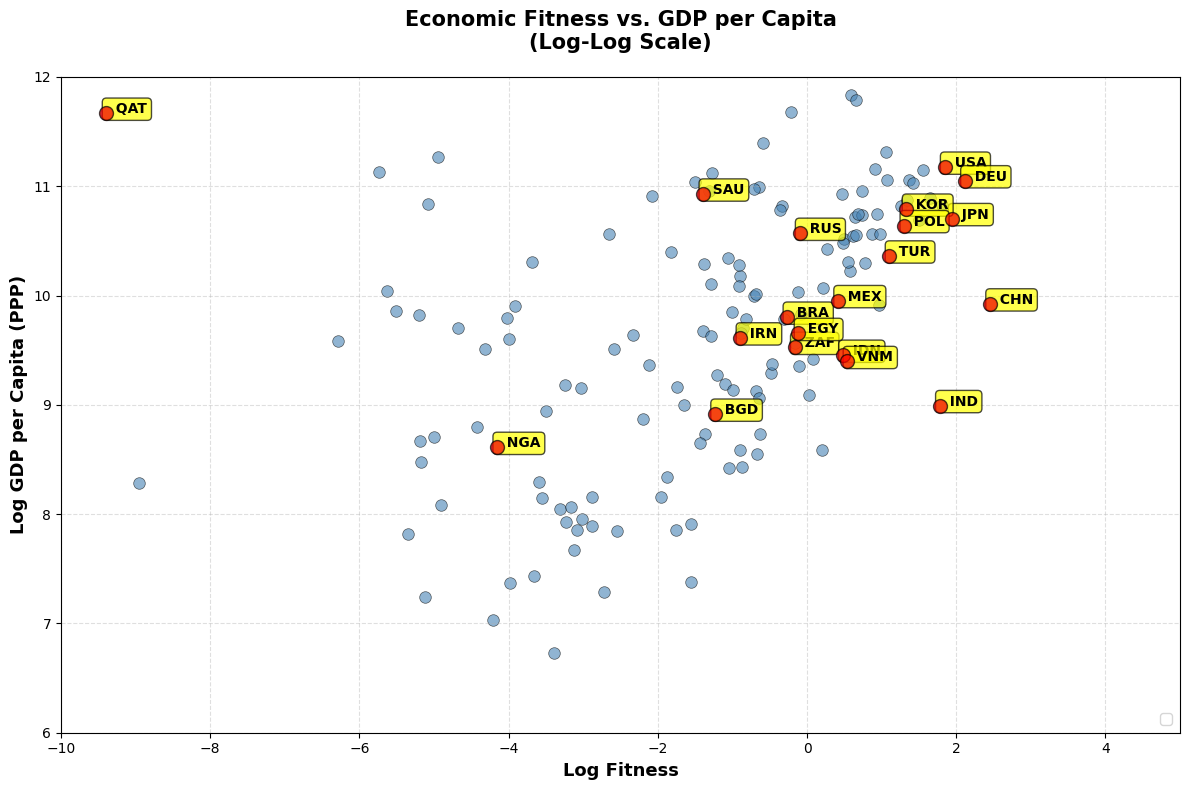

In [17]:
# Create the fitness-GDP plane
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot (log-log scale)
ax.scatter(np.log(df_merged['Fitness']), np.log(df_merged['gdp_pc']),
           alpha=0.6, s=70, color='steelblue', edgecolors='black', linewidths=0.5)

# Highlight specific countries
highlight_countries = [
    'IND', 'CHN', 'USA', 'NGA', 'BRA', 'RUS', 'SAU', 'DEU',
    'ZAF', 'JPN', 'MEX', 'IDN', 'EGY', 'VNM', 'BGD', 'QAT',
    'KOR', 'TUR', 'POL', 'IRN'
]

for country in highlight_countries:
    if country in df_merged['Country'].values:
        row = df_merged[df_merged['Country'] == country].iloc[0]
        ax.scatter(np.log(row['Fitness']), np.log(row['gdp_pc']),
                  s=100, color='red', alpha=0.7, edgecolors='black', linewidths=1, zorder=5)
        ax.text(np.log(row['Fitness']), np.log(row['gdp_pc']),
               f"  {country}", fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Labels and title
ax.set_xlabel('Log Fitness', fontsize=13, fontweight='bold')
ax.set_ylabel('Log GDP per Capita (PPP)', fontsize=13, fontweight='bold')
ax.set_title('Economic Fitness vs. GDP per Capita\n(Log-Log Scale)',
            fontsize=15, fontweight='bold', pad=20)

# Add grid
ax.grid(True, alpha=0.4, linestyle='--')

# Set axis limits for better visualization
ax.set_xlim([-10, 5])
ax.set_ylim([6, 12])


ax.legend(fontsize=11, loc='lower right')

plt.tight_layout()
plt.savefig('fitness_gdp_plane.png', dpi=300, bbox_inches='tight')
plt.show()


---
## Step 6: Product Complexity Analysis

In [18]:
# Load product descriptions from HS 2012 (third sheet)
hs_codes = pd.read_excel('HSCodeandDescription.xlsx', sheet_name=2)

# Filter to basic level (6-digit codes)
hs_codes_basic = hs_codes[hs_codes['IsBasicLevel'] == 1].copy()

# Create mapping with integer keys (to match our product codes)
code_to_description = {int(code): desc for code, desc in zip(hs_codes_basic['Code'], hs_codes_basic['Description'])}

# Extract chapter names (Level 2 - 2-digit codes)
hs_chapters = hs_codes[hs_codes['Level'] == 2].copy()
chapter_to_name = {str(code).zfill(2): desc for code, desc in zip(hs_chapters['Code'], hs_chapters['Description'])}

print(f"Loaded {len(code_to_description)} product descriptions from HS 2017")
print(f"Loaded {len(chapter_to_name)} HS chapters")
print(f"\nExample chapters:")
for ch, name in list(chapter_to_name.items())[:5]:
    print(f"  {ch}: {name}")

# Create DataFrame for products
products_clean = [p for i, p in enumerate(products) if not products_to_remove[i]]

df_complexity = pd.DataFrame({
    'Product_Code': products_clean,
    'Complexity': Q,
    'Ubiquity': ubi_clean
})

# Add descriptions
df_complexity['Description'] = df_complexity['Product_Code'].map(code_to_description)

# Sort by complexity
df_complexity_sorted = df_complexity.sort_values('Complexity', ascending=False)

print(f"\nTop 30 Most Complex Products:\n")
print(df_complexity_sorted[['Product_Code', 'Complexity', 'Ubiquity', 'Description']].head(30).to_string(index=False))

Loaded 5206 product descriptions from HS 2017
Loaded 97 HS chapters

Example chapters:
  01: Animals; live
  02: Meat and edible meat offal
  03: Fish and crustaceans, molluscs and other aquatic invertebrates
  04: Dairy produce; birds' eggs; natural honey; edible products of animal origin, not elsewhere specified or included
  05: Animal originated products; not elsewhere specified or included

Top 30 Most Complex Products:

 Product_Code  Complexity  Ubiquity                                                                                                                                                                                                    Description
        71233   90.491481       1.0                                                                                               Vegetables; jelly fungi (Tremella spp)), whole, cut, sliced, broken or in powder but not further prepared, dried
        71232   90.491481       1.0                                                 

In [19]:
print("\nTop 30 Least Complex (Most Ubiquitous) Products:\n")
print(df_complexity_sorted[['Product_Code', 'Complexity', 'Ubiquity', 'Description']].tail(30).to_string(index=False))


Top 30 Least Complex (Most Ubiquitous) Products:

 Product_Code   Complexity  Ubiquity                                                                                                                                                                                                                                              Description
       890800 1.230163e-31      34.0                                                                                                                                                                                                   Vessels and other floating structures; for breaking up
       120242 2.782906e-36      23.0                                                                                                                                                           Ground-nuts; other than seed, not roasted or otherwise cooked, shelled, whether or not broken,
       130120 2.782906e-36      17.0                                                       

In [20]:
# Analyze complexity by HS chapter (2-digit)
df_complexity['Chapter'] = df_complexity['Product_Code'].astype(str).str.zfill(6).str[:2]
df_complexity['Chapter_Name'] = df_complexity['Chapter'].map(chapter_to_name)

# Compute geometric mean of complexity (since it spans many orders of magnitude)
# Geometric mean = exp(mean(log(complexity)))
chapter_complexity = df_complexity.groupby(['Chapter', 'Chapter_Name']).agg({
    'Complexity': lambda x: np.exp(np.log(x).mean()),  # Geometric mean
    'Product_Code': 'count',
    'Ubiquity': 'mean'
}).round(4)

chapter_complexity.columns = ['Geometric_Mean_Complexity', 'Num_Products', 'Avg_Ubiquity']
chapter_complexity = chapter_complexity.sort_values('Geometric_Mean_Complexity', ascending=False)

print("\n" + "="*90)
print("GEOMETRIC MEAN COMPLEXITY BY HS CHAPTER")
print("="*90)
print("(Geometric mean used because complexity spans many orders of magnitude)\n")
print(chapter_complexity.head(20).to_string())

print("\n\nLeast Complex Chapters:")
print(chapter_complexity.tail(15).to_string())


GEOMETRIC MEAN COMPLEXITY BY HS CHAPTER
(Geometric mean used because complexity spans many orders of magnitude)

                                                                                                                                                                                                                              Geometric_Mean_Complexity  Num_Products  Avg_Ubiquity
Chapter Chapter_Name                                                                                                                                                                                                                                                               
37      Photographic or cinematographic goods                                                                                                                                                                                                    1.9187            31        7.6129
91      Clocks and watches and parts thereof              

---
## Summary

### What We Learned

1. **Economic Fitness**: Measures productive capabilities beyond GDP
   - Accounts for both diversification AND sophistication
   - Strong predictor of economic development

2. **Nested Structure**: World trade network shows hierarchical organization
   - Diverse countries make everything specialized countries make
   - Reveals development path: specialized → diversified

3. **Fitness-Complexity Algorithm**: Iterative method based on mutual feedback
   - Fitness: Export many complex products
   - Complexity: Made only by fit countries

4. **Fitness-GDP Relationship**: Strong correlation with interesting outliers
   - Resource-rich countries: High GDP, low fitness
   - Industrializing countries: High fitness, low GDP (growth potential)

---